## Import libraries

In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from keras import Sequential
from keras.layers import Input, Dense

## Read dataset

In [3]:
# Data loader function (from preprocessing notebook)
def data_loader(path='https://archive.ics.uci.edu/ml/machine-learning-databases/00597/garments_worker_productivity.csv',
                preprocessing=False):
    df = pd.read_csv(path)
    if preprocessing == True:
        df['date'] = pd.to_datetime(df['date'])
        df['department'] = df['department'].apply(lambda x: 'sewing' if x == 'sweing' else 'finishing')
        df['team'] = df['team'].apply(lambda x: 'Team'+str(int(x)))
        from sklearn.impute import KNNImputer
        imputer = KNNImputer()
        df[df.columns[5:]] = imputer.fit_transform(df.iloc[:,5:])
    return df

In [4]:
df = data_loader(preprocessing=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   object        
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    1197 non-null   float64       
 8   over_time              1197 non-null   float64       
 9   incentive              1197 non-null   float64       
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   float64       
 12  no_of_style_change     1197 non-null   float64       
 13  no_

# Machine Learning Approach

## Data Preprocessing

In [5]:
df.columns

Index(['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity'],
      dtype='object')

In [6]:
X_cat = df.iloc[:,1:5] #categorical features
X_num = df.iloc[:,5:-1] #numerical features
y = df.iloc[:,-1] #target

### Encoding categorical features

Apply one-hot encoding to features: 'quarter', 'department', 'day', 'team'.

In [7]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat_encoded = encoder.fit_transform(X_cat)
encoder.categories_

C:\Users\takhu\anaconda3\envs\illus\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
       dtype=object),
 array(['finishing', 'sewing'], dtype=object),
 array(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
       dtype=object),
 array(['Team1', 'Team10', 'Team11', 'Team12', 'Team2', 'Team3', 'Team4',
        'Team5', 'Team6', 'Team7', 'Team8', 'Team9'], dtype=object)]

In [8]:
X_cat_encoded

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

### Normalization

Apply min-max scaling to numeric features.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_num = scaler.fit_transform(X_num)

In [10]:
X = np.hstack((X_cat_encoded,X_num))

In [11]:
X.shape, y.shape

((1197, 34), (1197,))

### Train-Test Splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((957, 34), (957,), (240, 34), (240,))

## Model Development

### Multivariate Linear Regression

In [14]:

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
lr.score(X,y)

0.3051020956066872

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("RMSE:", mean_squared_error(y_test, lr.predict(X_test), squared=False))
print("MAE:", mean_absolute_error(y_test, lr.predict(X_test)))
print("MAPE:", mean_absolute_percentage_error(y_test, lr.predict(X_test)))

RMSE: 0.1420587152784801
MAE: 0.10575617722083333
MAPE: 0.18460408864556158


Text(0.5, 0, 'Actual Productivity')

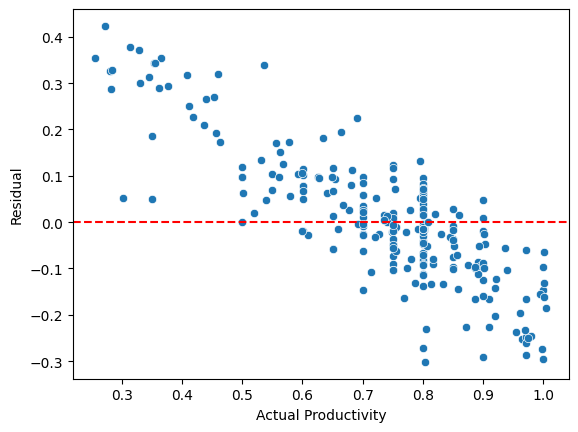

In [17]:
sns.scatterplot(x=y_test, y=lr.predict(X_test)-y_test)
plt.axhline(y=0,linestyle='--',color='r')
plt.ylabel('Residual')
plt.xlabel('Actual Productivity')

### Support Vector Regression

In [18]:
params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
          'C': [0.01, 0.1, 1.0, 10],
          'epsilon':[0.02, 0.05, 0.1, 0.2]}
svr = GridSearchCV(SVR(), params, cv=5, scoring='r2')
svr.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1.0, 10],
                         'epsilon': [0.02, 0.05, 0.1, 0.2],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='r2')

In [19]:
svr.best_params_

{'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}

In [20]:
svr.score(X_train,y_train)

0.30409097505848814

In [21]:
print("RMSE:", mean_squared_error(y_test, svr.predict(X_test), squared=False))
print("MAE:", mean_absolute_error(y_test, svr.predict(X_test)))
print("MAPE:", mean_absolute_percentage_error(y_test, svr.predict(X_test)))

RMSE: 0.1415599073716017
MAE: 0.1044788941810214
MAPE: 0.18675489994605374


Text(0.5, 0, 'Actual Productivity')

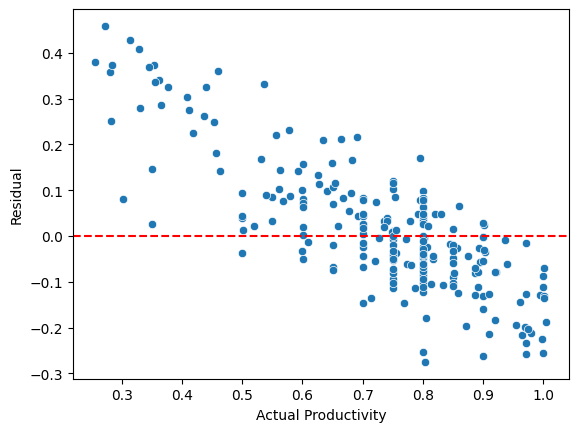

In [22]:
sns.scatterplot(x=y_test, y=svr.predict(X_test)-y_test)
plt.axhline(y=0,linestyle='--',color='r')
plt.ylabel('Residual')
plt.xlabel('Actual Productivity')

### Random Forest Regression

In [23]:
params = {'n_estimators':[10, 20, 50, 100],
          'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
          'max_features':['sqrt', 'log2', 1.0]}
rf = GridSearchCV(RandomForestRegressor(), params, cv=5, scoring='r2')
rf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_features': ['sqrt', 'log2', 1.0],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='r2')

In [24]:
rf.best_params_

{'criterion': 'absolute_error', 'max_features': 'log2', 'n_estimators': 100}

In [25]:
rf.score(X_train,y_train)

0.9106496229166643

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("RMSE:", mean_squared_error(y_test, rf.predict(X_test), squared=False))
print("MAE:", mean_absolute_error(y_test, rf.predict(X_test)))
print("MAPE:", mean_absolute_percentage_error(y_test, rf.predict(X_test)))

RMSE: 0.12026713450986529
MAE: 0.08076627831293753
MAPE: 0.14583729637026416


Text(0.5, 0, 'Actual Productivity')

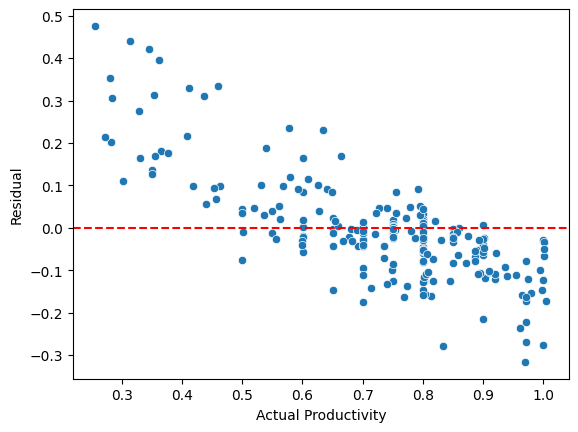

In [27]:
sns.scatterplot(x=y_test, y=rf.predict(X_test)-y_test)
plt.axhline(y=0,linestyle='--',color='r')
plt.ylabel('Residual')
plt.xlabel('Actual Productivity')

### XGBoost Regression

In [28]:
pip install xgboost

In [29]:
params = {'n_estimators':[10, 20, 50, 100],
          'max_depth':[3, 4, 5, 6, 7, 8]}
xgb = GridSearchCV(XGBRegressor(), params, cv=5, scoring='r2')
xgb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='r2')

In [30]:
xgb.best_params_

{'max_depth': 3, 'n_estimators': 20}

In [31]:
xgb.score(X_train,y_train)

0.610223465905257

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("RMSE:", mean_squared_error(y_test, xgb.predict(X_test), squared=False))
print("MAE:", mean_absolute_error(y_test, xgb.predict(X_test)))
print("MAPE:", mean_absolute_percentage_error(y_test, xgb.predict(X_test)))

RMSE: 0.12413350614632461
MAE: 0.0825478715747134
MAPE: 0.14793702777427992


Text(0.5, 0, 'Actual Productivity')

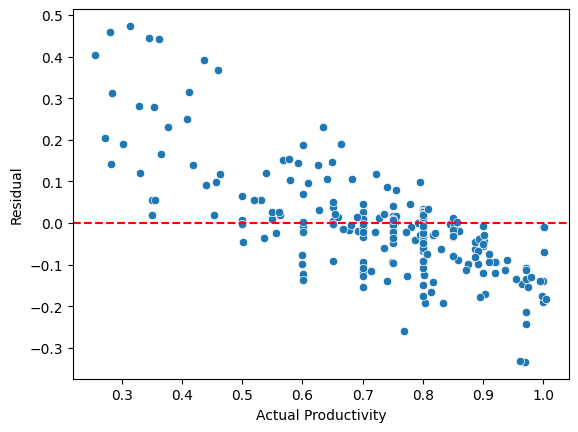

In [33]:
sns.scatterplot(x=y_test, y=xgb.predict(X_test)-y_test)
plt.axhline(y=0,linestyle='--',color='r')
plt.ylabel('Residual')
plt.xlabel('Actual Productivity')

### Artificial Neural Network

In [34]:
ann = Sequential()
ann.add(Input(34,))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

In [35]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2240      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [36]:
ann.compile(optimizer='adam', loss='mean_absolute_error')

In [37]:
ann.fit(X_train, y_train, epochs=100)

Epoch 1/100
30/30 [==============================] - 1s 994us/step - loss: 0.1510
Epoch 2/100
30/30 [==============================] - 0s 813us/step - loss: 0.1259
Epoch 3/100
30/30 [==============================] - 0s 481us/step - loss: 0.1196
Epoch 4/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1170
Epoch 5/100
30/30 [==============================] - 0s 570us/step - loss: 0.1154
Epoch 6/100
30/30 [==============================] - 0s 686us/step - loss: 0.1132
Epoch 7/100
30/30 [==============================] - 0s 584us/step - loss: 0.1116
Epoch 8/100
30/30 [==============================] - 0s 686us/step - loss: 0.1105
Epoch 9/100
30/30 [==============================] - 0s 574us/step - loss: 0.1086
Epoch 10/100
30/30 [==============================] - 0s 655us/step - loss: 0.1071
Epoch 11/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1060
Epoch 12/100
30/30 [==============================] - 0s 621us/step - loss: 0.1051
Epoch 13/100
30/3

30/30 [==============================] - 0s 749us/step - loss: 0.0535


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("RMSE:", mean_squared_error(y_test, ann.predict(X_test), squared=False))
print("MAE:", mean_absolute_error(y_test, ann.predict(X_test)))
print("MAPE:", mean_absolute_percentage_error(y_test, ann.predict(X_test)))

8/8 [==============================] - 0s 866us/step
RMSE: 0.15751896343484978
8/8 [==============================] - 0s 858us/step
MAE: 0.10939250790507125
8/8 [==============================] - 0s 657us/step
MAPE: 0.1995999842771692


8/8 [==============================] - 0s 715us/step


Text(0.5, 0, 'Actual Productivity')

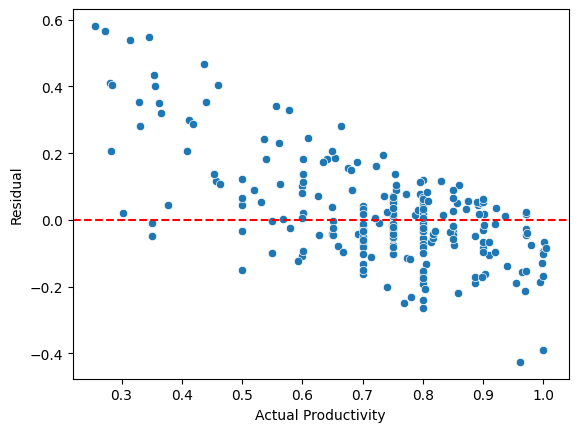

In [39]:
sns.scatterplot(x=y_test, y=ann.predict(X_test).reshape(-1)-y_test)
plt.axhline(y=0,linestyle='--',color='r')
plt.ylabel('Residual')
plt.xlabel('Actual Productivity')

## Model Ranking

In [40]:
results = {'LinearRegression': [0.142, 0.106, 0.185],
            'SupportVectorRegression': [0.142, 0.104, 0.187],
            'RandomForestRegression': [0.119, 0.081, 0.146],
            'XGBoostRegression': [0.124, 0.083, 0.148],
            'ArtificialNeuralNetwork': [0.145, 0.100, 0.181]}

In [41]:
results = pd.DataFrame(results).T
results.columns = ['RMSE', 'MAE', 'MAPE']

In [42]:
results

,RMSE,MAE,MAPE
LinearRegression,0.142,0.106,0.185
SupportVectorRegression,0.142,0.104,0.187
RandomForestRegression,0.119,0.081,0.146
XGBoostRegression,0.124,0.083,0.148
ArtificialNeuralNetwork,0.145,0.100,0.181


Nhận xét: Random Forest Regression cho kết quả dự đoán tốt nhất trên tập test.

## Build final pipeline

In [43]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [44]:
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[        
        ("cat", categorical_transformer, slice(0,4)),
        ("num", numeric_transformer, slice(4,13)),
    ]
)

In [45]:
Input = [('preprocess',preprocessor), 
         ('regressor', RandomForestRegressor(criterion='absolute_error', max_features='log2'))]

In [46]:
pipe = Pipeline(Input)

In [47]:
pipe.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  slice(0, 4, None)),
                                                 ('num', MinMaxScaler(),
                                                  slice(4, 13, None))])),
                ('regressor',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='log2'))])

In [48]:
pipe.score(X, y)

0.9152820750282689

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("RMSE:", mean_squared_error(y, pipe.predict(X), squared=False))
print("MAE:", mean_absolute_error(y, pipe.predict(X)))
print("MAPE:", mean_absolute_percentage_error(y, pipe.predict(X)))

RMSE: 0.050765830355456995
MAE: 0.032391067057581456
MAPE: 0.0596030721577706


In [50]:
pickle.dump(pipe, open('pipeline.sav', 'wb'))